In [17]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [18]:
spark = SparkSession.builder.getOrCreate()

In [40]:
MsNPC = spark.read.csv("DataUAP/Query + Visualization/MsNPC.csv", header=True, inferSchema=True)
MsPlayer = spark.read.csv("DataUAP/Query + Visualization/MsPlayer.csv", header=True, inferSchema=True)
MsWeapon = spark.read.csv("DataUAP/Query + Visualization/MsWeapon.csv", header=True, inferSchema=True)
MsWeaponType = spark.read.csv("DataUAP/Query + Visualization/MsWeaponType.csv", header=True, inferSchema=True)
TransactionDetail = spark.read.csv("DataUAP/Query + Visualization/TransactionDetail.csv", header=True, inferSchema=True)
TransactionHeader = spark.read.csv("DataUAP/Query + Visualization/TransactionHeader.csv", header=True, inferSchema=True)

MsNPC.registerTempTable("MsNPC")
MsPlayer.registerTempTable("MsPlayer")
MsWeapon.registerTempTable("MsWeapon")
MsWeaponType.registerTempTable("MsWeaponType")
TransactionDetail.registerTempTable("TransactionDetail")
TransactionHeader.registerTempTable("TransactionHeader")

In [127]:
res1 = spark.sql("SELECT WeaponTypeName, SUM(Quantity*WeaponPrice) AS PieChart FROM MsWeaponType mwt JOIN MsWeapon mw ON mwt.WeaponTypeId = mw.WeaponTypeId JOIN TransactionDetail td ON mw.WeaponId = td.WeaponId JOIN TransactionHeader th ON td.TransactionId = th.TransactionId WHERE YEAR(TransactionDate) = '2019' GROUP BY WeaponTypeName ORDER BY PieChart")
res1 = res1.toPandas()

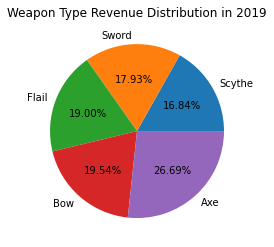

In [128]:
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(res1["PieChart"], labels=res1["WeaponTypeName"], autopct = '%.2f%%')
plt.show()

In [158]:
res2 = spark.sql("SELECT MONTH(TransactionDate) AS Month, COUNT(DISTINCT(th.PlayerId)) AS PlayerCount FROM MsPlayer mp JOIN TransactionHeader th ON mp.PlayerId = th.PlayerId JOIN TransactionDetail td ON th.TransactionId = td.TransactionId JOIN MsWeapon mw ON td.WeaponId = mw.WeaponId JOIN MsWeaponType mwt ON mw.WeaponTypeId = mwt.WeaponTypeId WHERE YEAR(TransactionDate) = '2019' AND WeaponTypeName LIKE 'Axe' GROUP BY MONTH(TransactionDate) ORDER BY Month ASC")
res2 = res2.toPandas()

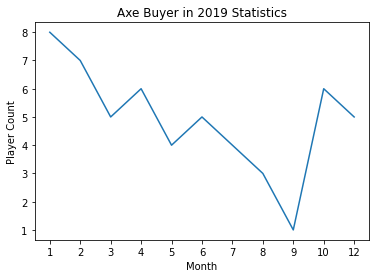

In [129]:
plt.title("Axe Buyer in 2019 Statistics")
plt.plot(res2["PlayerCount"])
plt.xticks(range(len(res2["Month"])), res2["Month"])
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [177]:
res3 = spark.sql("SELECT wn.WeaponName, COUNT(wn.WeaponName) AS Total FROM (SELECT PlayerName,MONTH(TransactionDate) AS MonthM, CASE WHEN SUM(Quantity * WeaponPrice) BETWEEN 1000000 AND 1499999 THEN 'Storm Breaker' WHEN SUM(Quantity * WeaponPrice) BETWEEN 1500000 AND 1999999 THEN 'NightFall' WHEN SUM(Quantity * WeaponPrice) > 2000000 THEN 'Extinction' END AS WeaponName FROM MsPlayer mp JOIN TransactionHeader th ON mp.PlayerID = th.PlayerID JOIN TransactionDetail td ON th.TransactionID = td.TransactionID JOIN MsWeapon mw ON mw.WeaponID = td.WeaponID WHERE YEAR(TransactionDate) = '2019' AND PlayerGender LIKE ('Female') GROUP BY PlayerName, MonthM HAVING SUM(Quantity * WeaponPrice) > 1000000) AS wn GROUP BY wn.WeaponName")
res3 = res3.toPandas()

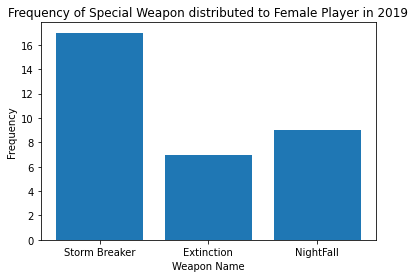

In [168]:
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.bar(res3["WeaponName"], res3["Total"])
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.show()

In [178]:
res4 = spark.sql("SELECT x.Month, COUNT(x.PlayerId) as PlayerCount FROM(SELECT th.PlayerId, MONTH(TransactionDate) as Month FROM MsPlayer mp JOIN TransactionHeader th ON mp.PlayerId = th.PlayerId JOIN TransactionDetail td ON th.TransactionId = td.TransactionId JOIN MsWeapon mw ON td.WeaponId = mw.WeaponId JOIN MsWeaponType mwt ON mw.WeaponTypeId = mwt.WeaponTypeId WHERE YEAR(TransactionDate) = 2019 GROUP BY th.PlayerId, Month HAVING COUNT(DISTINCT(mw.WeaponTypeId)) >=3) as x GROUP BY x.Month ORDER BY x.Month")
res4 = res4.toPandas()

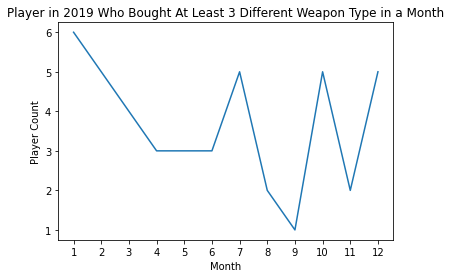

In [179]:
plt.title("Player in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.plot(res4["PlayerCount"])
plt.xticks(range(len(res4["Month"])), res4["Month"])
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [181]:
res5 = spark.sql("SELECT A.Popularity, COUNT(A.Popularity) AS Frequency FROM (SELECT NPCName, CASE WHEN SUM(Quantity * WeaponPrice) >= 15000000 THEN 'Very Popular' WHEN SUM(Quantity * WeaponPrice) <2500000 THEN 'Not Popular' WHEN SUM(Quantity * WeaponPrice) BETWEEN 7500000 AND 14999999 THEN 'Popular' ELSE 'Quite Popular' END AS Popularity FROM MsNPC NPC JOIN TransactionHeader TH ON NPC.NPCId = TH.NPCID JOIN TransactionDetail TD ON TH.TransactionID = TD.TransactionID JOIN MsWeapon MW ON TD.WeaponID = MW.WeaponID GROUP BY NPCName HAVING COUNT(DISTINCT(TH.PlayerID)) >=5) AS A WHERE A.Popularity ='Very Popular' OR A.Popularity ='Not Popular' OR A.Popularity = 'Quite Popular' OR A.Popularity = 'Popular' GROUP BY A.Popularity")
res5 = res5.toPandas()

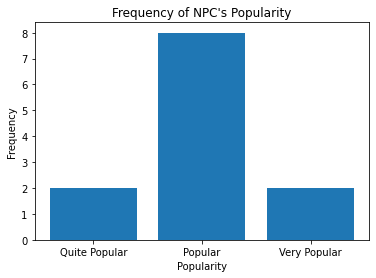

In [183]:
plt.title("Frequency of NPC's Popularity")
plt.bar(res5["Popularity"], res5["Frequency"])
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()